# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# builtin lib
import joblib
import json
import typing as t
from pathlib import Path
from importlib import reload

# third party lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

from scipy.stats import uniform, randint, loguniform

# local library
import py_modules.custom_sklearn as csk
import py_modules.utils as utils
reload(csk) # reload modules for debugging purpose
reload(utils)

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# declare constant value
META_DATA_DIR = Path('./metadata')
DATA_DIR = Path('./data')
CLEAN_DATA_DIR = Path('./clean-data')
MODEL_DIR = Path('./models')
SUBMIT_DIR = Path('./submissions/')

META_DATA_FILENAMES = ['age-data.json', 'interval-data.json', 'nominal-data.json', 'ordinal-data.json']

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv(DATA_DIR / 'Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv(DATA_DIR / 'Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/boonchuay/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Import metadata
metadatas: t.Dict = {}

for filename in META_DATA_FILENAMES:

    with open(META_DATA_DIR / filename, 'r') as fp:
        metadatas[filename.replace('.json', '')] = json.load(fp)

### Feature selection

In [5]:
def get_feature2unk(metadatas: t.Dict[str, t.List[t.Dict]]) -> t.Dict[str, t.List]:
    '''Convert metadata dict to dict which map feature name to its unknown value

    Args:
        metadata: metadata retrieve from json file
    
    Returns:
        feature2unk: dict that map feature name to its unknown encoding value
    '''

    feature2unk = {}

    for _, metas in metadatas.items():

        for meta in metas:
            feature2unk[meta['feature']] = meta['unknown_value']

    return feature2unk


def get_feature2level(metadatas: t.Dict[str, t.List[t.Dict]]) -> t.Dict[str, t.List]:
    '''Convert metadata dict to dict which map feature name to its data level

    Args:
        metadata: metadata retrieve from json file
    
    Returns:
        feature2unk: dict that map feature name to its unknown encoding value
    '''

    feature2level = {}

    for datalevel, metas in metadatas.items():

        for meta in metas:
            feature2level[meta['feature']] = datalevel

    return feature2level


def encode_unknown_value(df: pd.DataFrame, features: t.List[str], feature2unk: t.Dict) -> pd.DataFrame:
    '''Encode unkown encoding value to NaN for the given features in df

    Args:
        df: target dataframe
        features: feature list that will be encoded
        feature2unk: dict that maps feature to its unknown value

    Returns:
        df_: dataframe that is encoded
    '''
    
    df_ = df.copy()

    for feature in features:

        unk = feature2unk[feature] if feature in feature2unk else None

        if unk is not None:
            df_[feature].replace(unk, np.nan, inplace=True)

    return df_

In [6]:
def plot_missing_value(df, feature2unk):

    df_enc = encode_unknown_value(df, df.columns, feature2unk)
    missing_perc = np.zeros(len(df.columns))
    
    for i, feature in enumerate(df.columns):
        missing_perc[i] = df_enc[feature].isnull().sum() / len(df)

    # plt.bar(df.columns, missing_perc)
    plt.figure(figsize=(32, 9))
    sns.barplot(df.columns, missing_perc)
    plt.xticks(rotation=90)


def identify_too_much_missing_features(df, feature2unk, threshold=0.3) -> t.List[str]:

    df_enc = encode_unknown_value(df, df.columns, feature2unk)
    miss_features = []

    for _, feature in enumerate(df.columns):

        missing_perc = df_enc[feature].isnull().sum() / len(df)
        if missing_perc >= threshold:
            print(f'{feature} have too much missing of {missing_perc}')
            miss_features.append(feature)

    return miss_features

In [7]:
def identify_too_much_missing_rows(df, feature2unk, threshold=0.3) -> pd.Series:
    # encode unknown value to Nan with a given dict maps from feature string to its list of unk values

    df_enc = encode_unknown_value(df, df.columns, feature2unk)
    missing_row = df_enc.isnull().sum(axis=1) / df.shape[1] >= threshold

    return missing_row


def identify_high_correlated(df: pd.DataFrame, threshold: float=0.7) -> t.List[str]:
    '''Identify high correlated features and return as a list of string
    If the returned features is removed, all the diagonal elements of the 
    corr matrix will be lower than threshold
    '''

    # calculate correlation matrix
    corr = df.corr()

    # init remaining features 
    remaining_features = list(corr.columns)
    high_corr_features = []

    for f1 in corr.columns:
        for f2 in remaining_features:

            # check the features that doesn't itselves and 
            # the features that its correlation greater than threshold
            if f1 != f2 and corr[f1].loc[f2] >= threshold:
                remaining_features.remove(f1)
                high_corr_features.append(f1)
                break

    return high_corr_features

In [8]:
def identify_features_not_exist(df, metadata: t.Dict[str, t.Dict]):
    '''Identify the features in the df that doesn't exist in data dict "metadata"
    '''

    # identify all features
    all_features = get_all_features_in_metadata(metadata)
    exist_features = df.columns
    not_exist_features = []

    # check feature in all exist features
    # if feature doesn't exist record it and return as results
    for feature in exist_features:
        if feature not in all_features:
            not_exist_features.append(feature)

    return not_exist_features


def get_all_features_in_metadata(metadata: t.Dict[str, t.Dict]):

    # find all features exist in metadata
    all_features = []

    for datalevel, metas in metadatas.items():

        for meta in metas:
            all_features.append(meta['feature'])

    return all_features

In [9]:
def identify_cardinality(df: pd.DataFrame, feature2level: t.Dict, threshold=15) -> t.List[str]:
    '''For nominal features, if its cardinality exceed 15, I will filtered it out
    Since it will make dimensions too high when it is encoded with one hot encoder
    '''

    cardinal_features = []

    for feature in df.columns:
        if feature in feature2level and feature2level[feature] == 'nominal-data':

            # for nominal features, find its unique values 
            # if its unique values exceed threshold, record it
            if df[feature].value_counts().shape[0] >= threshold:
                cardinal_features.append(feature)

    return cardinal_features


def identify_quasiconstant(df: pd.DataFrame, feature2level: t.Dict, threshold=0.9) -> t.List[str]:
    '''For ordinal and nominal features, if all of the value in the column is almost constant (greater than threshold), I will remove it, since it not give much information
    '''

    quasi_constant_features = []

    for feature in df.columns:
        if feature in feature2level and (feature2level[feature] == 'nominal-data' or feature2level[feature] == 'ordinal-data'):

            # for ordinal and nominal features, if the the most frequent features exceed 90%
            # record it 
            value_count = df[feature].value_counts()
            if value_count.iloc[0] / value_count.sum() >= threshold:
                quasi_constant_features.append(feature)

    return quasi_constant_features

In [10]:
def identify_nominal_and_non_nominal_features(features: t.List[str], feature2level: t.Dict[str, str]) -> t.Tuple[t.List[str], t.List[str], t.List[str]]:
    '''Given list of feature names, identify the feature that is nominal and non-nominal 
    and return as a Tuple of these two lists
    '''

    nominal_features = []
    non_nominal_features = []
    non_exist_features = []

    for feature in features:

        if feature not in feature2level:
            non_exist_features.append(feature)
            continue

        if feature2level[feature] == 'nominal-data':
            nominal_features.append(feature)
        else:
            non_nominal_features.append(feature)

    return nominal_features, non_nominal_features, non_exist_features

In [11]:
def plot_pca(x_ticks, heights, *, n_comps, title='cumsum explain variance ratio'):

    # plot cumsum
    plt.bar(x_ticks, heights)

    # plot y value at threshold level
    plt.plot([x_ticks[0], x_ticks[n_comps-1]], [heights[n_comps-1], heights[n_comps-1]], 'r--')

    # plot x value at threshold level
    plt.plot([x_ticks[n_comps-1], x_ticks[n_comps-1]], [heights[n_comps-1], 0], 'r--')

    plt.title(f'{title}, chosen comps = {n_comps}')


def plot_kmeans(x_ticks: np.ndarray, heights: t.List[float], *, title='kmeans'):

    # plot cumsum
    plt.plot(x_ticks, heights, 'o-')

    # plot diag value
    plt.plot([x_ticks[0], x_ticks[-1]], [heights[0], heights[-1]], 'r--')

    plt.title(f'{title}')

In [12]:
def plot_clustering_results(cluster_results: np.ndarray, is_customer: np.ndarray, n_clusters: int):


    x = np.arange(n_clusters)+1  # the label locations
    width = 0.35  # the width of the bars

    # identify the number of each cluster for general population versus existing customers
    general_value_count = np.unique(cluster_results[is_customer==0], return_counts=True)[1]
    customer_value_count = np.unique(cluster_results[is_customer==1], return_counts=True)[1]

    # convert number to proportion
    general = general_value_count / general_value_count.sum()
    customer = customer_value_count / customer_value_count.sum()

    # create subplot for plotting mult legend barplot
    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, general, width, label='General population')
    rects2 = ax.bar(x + width/2, customer, width, label='Customer')

    plt.legend()

In [13]:
def build_pipeline(scaler, clf) -> Pipeline:

    pipeline = Pipeline(
        [('scaler', scaler),
        ('estimator', clf)]
    )

    return pipeline


def build_cv(distributions, clf, *, random_state=292, scoring='roc_auc') -> RandomizedSearchCV:

    cv_clf = RandomizedSearchCV(clf, distributions, random_state=random_state, scoring=scoring)
    return cv_clf

In [14]:
def append_cluster_feature(clean_pipe_fn, clustering_pipe_fn, X: pd.DataFrame) -> pd.DataFrame:

    # load cleaning pipeline
    with open(MODEL_DIR / clean_pipe_fn, 'rb') as fp:
        cleaning_pipeline_sv = joblib.load(fp)

    # load clustering pipeline
    with open(MODEL_DIR / clustering_pipe_fn, 'rb') as fp:
        clustering_pipeline = joblib.load(fp)

    # clean the mailout train data
    X_train_clean = cleaning_pipeline_sv.transform(X)

    # predict the cluster of the mailout train
    X_train_cluster = clustering_pipeline.predict(X_train_clean)

    X_train_clean_wcluster = X_train_clean.copy()
    X_train_clean_wcluster['CLUSTER'] = X_train_cluster

    return X_train_clean_wcluster

In [109]:
def full_predict(*, X: pd.DataFrame, model_name: str, clean_pipe_fn: str, clustering_pipe_fn: str) -> t.Tuple[np.ndarray, np.ndarray]:
    '''Load the persist model from joblib and predict the data
    '''

    X_wcluster = append_cluster_feature(clean_pipe_fn, clustering_pipe_fn, X)

    # load the model
    with open(MODEL_DIR / model_name, 'rb') as fp:
        clf = joblib.load(fp)

    # predict the data
    pred_proba = clf.predict_proba(X_wcluster)
    pred = clf.predict(X_wcluster)

    return pred_proba, pred


def generate_submission_results(*, X: pd.DataFrame, pred_proba: np.ndarray,submission_fn: str):

    results = pd.DataFrame({'LNR': X['LNR'], 'RESPONSE': pred_proba[:, 1]})
    results.to_csv(SUBMIT_DIR / submission_fn, index=False)

In [15]:
# indentify usefule data structure from metadatas
feature2unk = get_feature2unk(metadatas)
feature2level = get_feature2level(metadatas)

### Observe raw data stat

In [16]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [17]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [18]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [19]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


All of the features seems to be of integer type.

In [20]:
azdias.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 366 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

In [21]:
customers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 369 columns):
LNR                            int64
AGER_TYP                       int64
AKT_DAT_KL                     float64
ALTER_HH                       float64
ALTER_KIND1                    float64
ALTER_KIND2                    float64
ALTER_KIND3                    float64
ALTER_KIND4                    float64
ALTERSKATEGORIE_FEIN           float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                 object
CAMEO_DEUG_2015                object
CAMEO_INTL_2015                object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float6

There are around 5 features that are string type, which have to be label encoded.

In [22]:
# identify the features that only customers have
customers_only_features = set(customers.columns) - set(azdias.columns)
print(customers_only_features)

{'CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'}


Almost all of the features in this dataset have its unique value of unknown value. For example, D19_LOTTO have 0 and NaN as unknown value. Thus, I need to manually checking the "DIAS Attributes - Values 2017.xlsx" file to label and record it in json file in metadata dir.

### Observe too much missing features

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


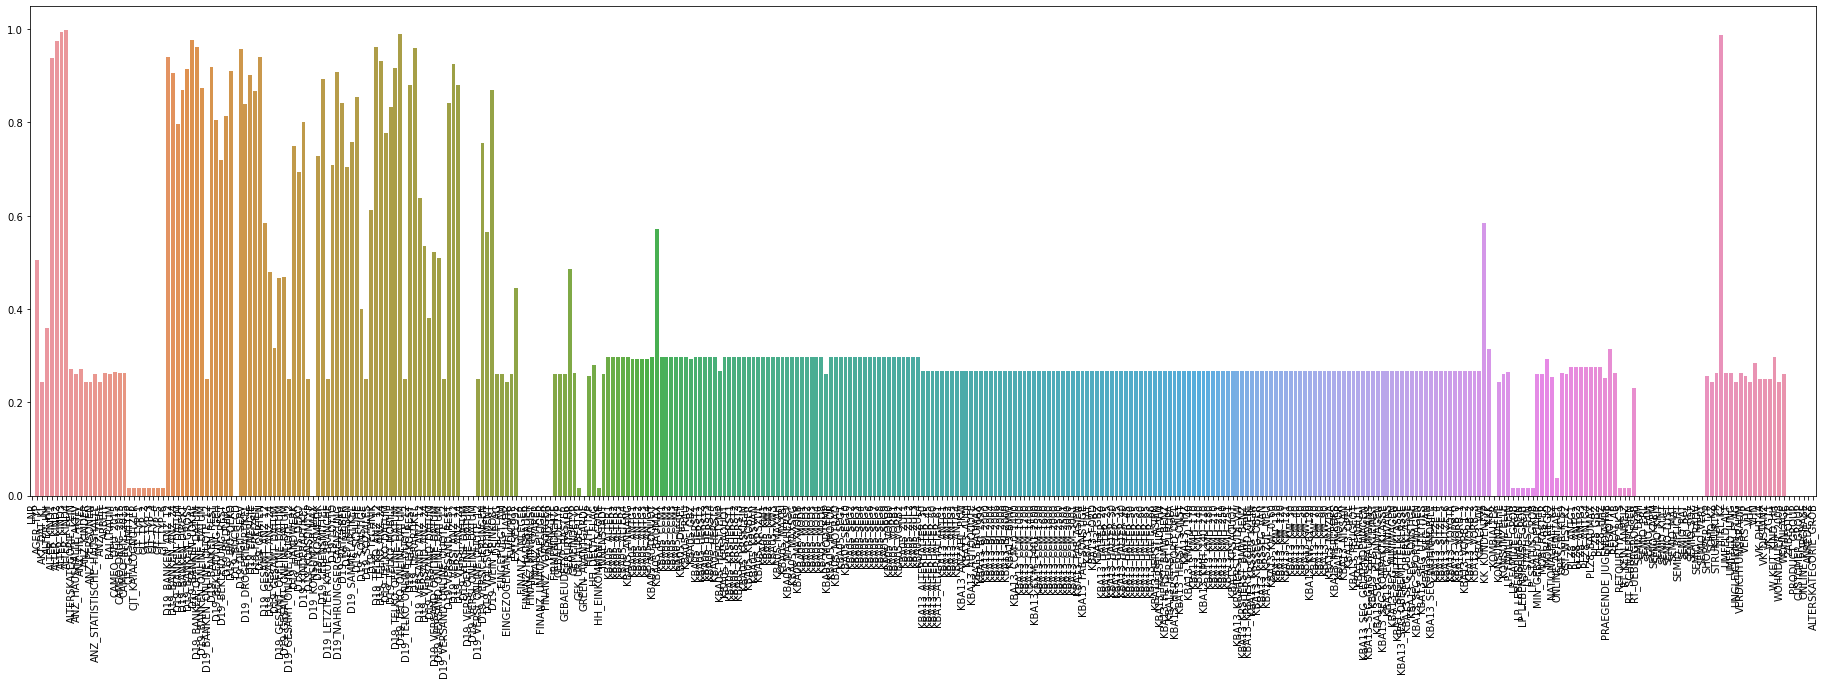

In [37]:
plot_missing_value(customers, feature2unk)

In [38]:
# identify too much missing features to be filtered out later
customer_miss_features = identify_too_much_missing_features(customers, feature2unk)
azdias_miss_features = identify_too_much_missing_features(azdias, feature2unk)

miss_features = list(set(customer_miss_features).union(set(azdias_miss_features)))

AGER_TYP have too much missing of 0.5047586250078266
ALTER_HH have too much missing of 0.35870744891783024
ALTER_KIND1 have too much missing of 0.9386074760503412
ALTER_KIND2 have too much missing of 0.9733892680483376
ALTER_KIND3 have too much missing of 0.9933473170120845
ALTER_KIND4 have too much missing of 0.9987686014234133
D19_BANKEN_ANZ_12 have too much missing of 0.9399849727631332
D19_BANKEN_ANZ_24 have too much missing of 0.9063354413207272
D19_BANKEN_DATUM have too much missing of 0.7970801243921274
D19_BANKEN_DIREKT have too much missing of 0.8699413520338948
D19_BANKEN_GROSS have too much missing of 0.9134472898795734
D19_BANKEN_LOKAL have too much missing of 0.9775374115584496
D19_BANKEN_OFFLINE_DATUM have too much missing of 0.9611274601882579
D19_BANKEN_ONLINE_DATUM have too much missing of 0.8744234341410473
D19_BANKEN_REST have too much missing of 0.9195990649719283
D19_BEKLEIDUNG_GEH have too much missing of 0.8048024544486883
D19_BEKLEIDUNG_REST have too much missin

### Observe too much missing rows

In [42]:
azdias_miss_rows = identify_too_much_missing_rows(azdias, feature2unk)
customer_miss_rows = identify_too_much_missing_rows(customers, feature2unk)

print(f'too much missing rows of azdias is about {azdias_miss_rows.sum()/len(azdias_miss_rows)*100:.2f}')
print(f'too much missing rows of customers is about {customer_miss_rows.sum()/len(customer_miss_rows)*100:.2f}')

too much missing rows of azdias is about 15.69
too much missing rows of customers is about 28.51


### Identify the features that is too related to the other features

In [40]:
azdias_high_cor_features = identify_high_correlated(azdias[set(azdias.columns) - set(azdias_miss_features)])
customer_high_cor_features = identify_high_correlated(customers[set(customers.columns) - set(customer_miss_features)])

In [41]:
corr_temp = azdias[set(azdias.columns) - set(azdias_miss_features) - set(azdias_high_cor_features)].corr()

### Identify and analyze the features that doesn't exist in the given data dict

In [42]:
azdias_not_exist = identify_features_not_exist(azdias, metadatas)
customer_not_exist = identify_features_not_exist(customers, metadatas)

The features that doesn't exist in the datadict may not worth the risk to use in the model. Since it will not be able to explain the results using unknown features.

### Identify too much cardinality

In [43]:
azdias_cardinal_features = identify_cardinality(azdias, feature2level)
customer_cardinal_features = identify_cardinality(customers, feature2level)

### Identify quasi constant features

In [44]:
azdias_quasicons_features = identify_quasiconstant(azdias, feature2level)
customer_quasicons_features = identify_quasiconstant(customers, feature2level)

## Data cleaning  
In the previous section, we observe the data and identify uncessary features using the following techniques  

1. Filter too much missing features. 
2. Filter too much missing rows.  
3. Filter too correlated features.  
4. Filter the features that doesn't exist in data dict for explanation after generating results. 
5. Filter too much cardinality  
6. Filter quasi constant features. 

In this section, I will filter out the non-selected features and perform data cleaning as follows:  
  
0. Filter the rows that doesn't give much information (too missing feature for that individual)
1. Select only the selected features from full dataframe  
2. Encode the unknown value with np.nan
3. Fill the missing data with median values. 
4. Encode the nominal data into one hot encoding.  
5. Composing the above two steps into pipeline for reuseable purposes.
6. Save the clean data for further processing in the unsupervised model

In [45]:
selected_features = set(azdias.columns) - set(azdias_miss_features) - set(customer_miss_features) - set(customer_miss_features) - set(azdias_high_cor_features) - set(customer_high_cor_features) - set(azdias_not_exist) - set(customer_not_exist) - set(customer_cardinal_features) - set(azdias_cardinal_features) - set(azdias_quasicons_features) - set(customer_quasicons_features)

In [23]:
# persist selected features in json
# with open(META_DATA_DIR / 'selected_features.json', 'w') as fp:
#     json.dump(list(selected_features), fp)

### Building pipeline

In [24]:
# load selected_features
with open(META_DATA_DIR / 'selected_features.json', 'r') as fp:
    selected_features = json.load(fp)

In [37]:
# identify nom and non-nom features
sel_nom_features, sel_non_nom_features, sel_non_exist_features = identify_nominal_and_non_nominal_features(selected_features, feature2level)

# build individual transformer
sel_tf = csk.SelectColumnsTransformer(selected_features=selected_features)
unk_enc = csk.EncodeUnknownTransformer(feature2unk=feature2unk)
med_imputer = csk.PandasImputer(imputer=SimpleImputer(strategy='median'))
nom_enc = csk.NominalEncoder(nominal_col=sel_nom_features, non_nominal_col=sel_non_nom_features)

# compose to pipeline
cleaning_pipeline = Pipeline(
    [
        ('column_selection_tf', sel_tf),
        ('unknown_val_encoder', unk_enc),
        ('median_imputer', med_imputer),
        ('nominal_encoder', nom_enc)
    ]
)

In [50]:
# filter row that is too much missing feature
# since it should not be compose in the pipeline
filtered_azdias = azdias.loc[~azdias_miss_rows]
filtered_customers = customers.loc[~customer_miss_rows]

In [51]:
# concat azdias and customers
azdias_and_customers = pd.concat([filtered_azdias[selected_features], filtered_customers[selected_features]])

In [53]:
# fit and transform concated dataframe
clean_azdias_and_customers = cleaning_pipeline.fit_transform(azdias_and_customers)

In [56]:
# save clean azdias and customers data for unsupervised model
clean_azdias_and_customers.to_csv(CLEAN_DATA_DIR / 'clean_azdias_and_customers.csv', index=False)

# save cleaning pipeline 
with open(MODEL_DIR / 'cleaning_pipeline.joblib', 'wb') as fp:
    joblib.dump(cleaning_pipeline, fp)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [57]:
# load clean azdias and customers data
clean_azdias_and_customers = pd.read_csv(CLEAN_DATA_DIR / 'clean_azdias_and_customers.csv')

In this section, I will implement unsupervised model for clustering the general population and existing customers using the following steps  

1. Scale the features on cleaning data. 
2. Implement PCA to reduce the dimensionality (this is optional, if it is not make the model clustring data the data better, I will drop it since it make explanation on the results more harder)  

    2.1 Calculate appropriate number of components for PCA.  
    2.2 Memorize the number for using in the pipeline.  

3. Implement MinibatchKMeans to clustering the results (mini batch is faster for large dataset) 

    3.1 Calculate appropriate number of clusters for KMeans.  
    3.2 Memorize the number for using in the pipeline.  
    
4. Compose the above steps into reuseable pipeline

In [62]:
# create the label array for indicating the existing customers and normal population
is_customer = np.hstack([np.zeros(len(filtered_azdias)), np.ones(len(filtered_customers))])

In [66]:
# scale the clean data 
scaler = StandardScaler()
clean_scaled_az_cus = scaler.fit_transform(clean_azdias_and_customers)

### Identify appropriate n components for PCA

In [133]:
pca = PCA(random_state=42)
n_comp, cumsum_var_ratio = utils.calculate_appropriate_PCA_n_comp(pca=pca, X=clean_scaled_az_cus)

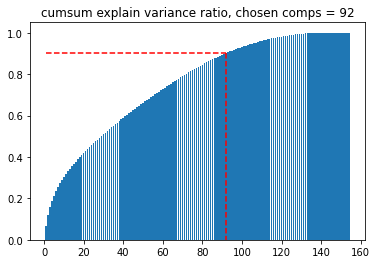

In [134]:
# visualize n components for PCA result
plot_pca(np.arange(1, len(cumsum_var_ratio)+1), cumsum_var_ratio, n_comps=n_comp)

### Identify appropriate n cluster for KMeans

In [160]:
# init kmeans and calculating inertias 
km = MiniBatchKMeans(random_state=101, batch_size=128)
clean_scaled_pcs_az_cus = pca.fit_transform(clean_scaled_az_cus)

inertias = utils.calculate_appropriate_n_cluster_KMeans(km=km, X=clean_scaled_pcs_az_cus)

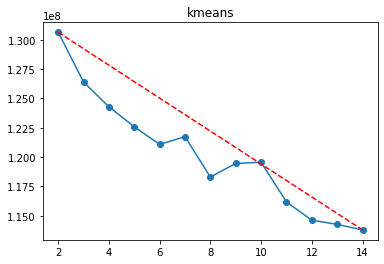

In [165]:
plot_kmeans(np.arange(1, len(inertias) + 1)+1, inertias)

From the plot of minibatch Kmeans, the graph is unstable because the minibatch kmeans stuck at local optima (it is a tradeoff for the speed). Number clusters of 8 is the elbow point since its perpendicular distance to the red line is largest.

In [188]:
n_clusters = 8

### Build the unsupervised pipeline

In [209]:
clustering_pipeline = Pipeline(
    [
        ('scaler', scaler),
        ('pca', PCA(n_components=n_comp, random_state=42)),
        ('minibatch_kmeans', MiniBatchKMeans(n_clusters=8, random_state=101, batch_size=128))]
)

In [210]:
# fit and predict from the pipeline
cluster_results = clustering_pipeline.fit_predict(clean_azdias_and_customers)

### Visualize and explain the clustering results

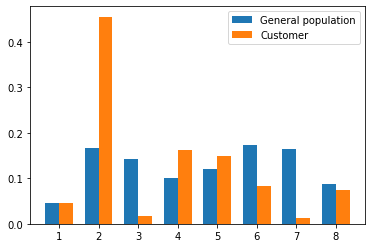

In [211]:
# compare the proportion of each cluster for general population and existing customers
plot_clustering_results(cluster_results, is_customer, n_clusters)

We can see that, there are almost none of existing customers clustered as group 3 and 7. While almost half of the existing customers classified as group 2!  

We will further examine in these cluster for finding an explanation for this.

In [217]:
cluster_centers_df = pd.DataFrame(
    clustering_pipeline['minibatch_kmeans'].cluster_centers_,
    columns=[f'comp_{i}' for i in range(1, n_comp+1)])

In [220]:
cluster_centers_df.loc[[1, 2, 6]].T

,1,2,6
comp_1,-3.275836,4.885325,2.060756
comp_2,-1.268584,-0.767055,-2.804616
comp_3,1.668870,0.598131,-1.082755
comp_4,-0.634295,0.211406,0.753900
comp_5,-0.324155,-0.589132,0.060165
...,...,...,...
comp_88,-0.024153,-0.041341,0.034608
comp_89,0.102081,0.102674,-0.046198
comp_90,-0.000527,0.006272,-0.022498
comp_91,-0.010618,0.036284,0.025498


In [269]:
def plot_pca_components_coeff(*, pca: PCA, comp: int, orig_col_names: t.List[str], threshold=20):

    # extract coeff of orig features
    comp_coeff = pd.DataFrame(pca.components_[comp-1].reshape(1, -1), columns=orig_col_names).T

    # sort by its absolute value and only extract orig value
    asc_sorted_coeff = comp_coeff.sort_values(by=0, ascending=True, axis=0).iloc[:, 0]
    desc_sorted_coeff = comp_coeff.sort_values(by=0, ascending=False, axis=0).iloc[:, 0]

    # horizontal barplot for positive coeff
    plt.barh(asc_sorted_coeff.index.values[-threshold:], asc_sorted_coeff.iloc[-threshold:])
    plt.title(f'sorted pos feature coeff for component {comp}')
    plt.show()

    # horizontal barplot for negative coeff
    plt.barh(desc_sorted_coeff.index.values[-threshold:], desc_sorted_coeff.iloc[-threshold:])
    plt.title(f'sorted neg feature coeff for component {comp}')
    plt.show()

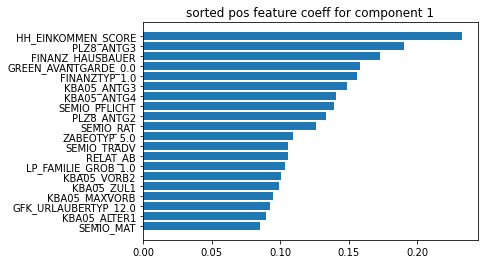

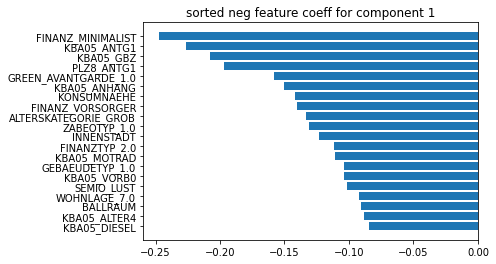

In [270]:
plot_pca_components_coeff(pca=clustering_pipeline['pca'], comp=1, orig_col_names=clean_azdias_and_customers.columns)

Since there are 92 components in the model, it is impossible to explain all of its components. So, we will only extract the first components which contains the most explainable variance ratio as our representative of the group.  

1. Cluster 1, which is the group of person who likely to be existing customers have negative coeff of the first components. It means that this group have high value of the original features that have negative coeff. In this case, it is.  

    1.1 FINANZ_MINIMALIST --> low financial interest (low debt)  
    1.2 KBA05_ANTG1 --> have 1-2 family homes   
    1.3 KBA05_GBZ --> high numbers of building in the cell  

2. Cluster 2, 6, which is the group of person who unlikely to be existing customers have positive coeff of the first components. It means that this group have high value of the original features that have positive coeff. In this case, it is:  

    1.1 HH_EINKOMMEN_SCORE --> low income  
    1.2 PLZ8_ANTG3 --> have 6-10 family in the house    
    1.3 FINANZ_HAUSBAUER --> low main focuse on the own house (doesn't interest to buy the house)

In [271]:
# save the clustering pipeline
with open(MODEL_DIR / 'clustering_pipeline.joblib', 'wb') as fp:
    joblib.dump(clustering_pipeline, fp)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In this section, the task is to classify the individual who response to Arvato's email. I will implement the following steps to solve this problems.  

1. Clean the data  
    1.1 Filter out the too incomplete row as it is not give much information  
    1.2 Fit and clean the mailout train data using the cleaning pipeline that I have build in the previous section.  
2. Cluster the group of mailout train data using the the previous clustering pipeline and add as new features.  
3. Build classification pipeline with these sub components  
    3.1 scaler transformer.  
    3.2 classificiation estimator using Logistic regression, RandomForest and Adaboost  


But first, let's observe the balance of the label. Since the imbalance dataset is the most important thing in choosing metrics to evaluate the model!

### Observe the balance of the label

In [3]:
mailout_train = pd.read_csv(DATA_DIR / 'Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/home/korntewin/Documents/capstone-arvato-customer-segmentation/env-capstone/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<BarContainer object of 2 artists>

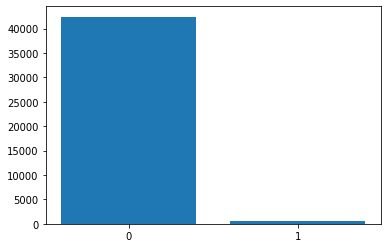

In [16]:
value_counts = mailout_train['RESPONSE'].value_counts()
plt.bar(value_counts.index.astype('str'), value_counts)

In [19]:
# observe the percentage of each label
value_counts / value_counts.sum() * 100

0    98.761696
1     1.238304
Name: RESPONSE, dtype: float64

Wow, we can see that the label of the data is heavily imbalance. There is only 1.2% of the individual who response to the mailout!

In [17]:
# identify too much missing rows
mailout_train_miss_rows = identify_too_much_missing_rows(mailout_train, feature2unk)

# filter out too much missing rows
filter_row_mailout_train = mailout_train.loc[~mailout_train_miss_rows]

In [18]:
# extract train and label data
full_X, full_y = filter_row_mailout_train.drop(columns=['RESPONSE']), filter_row_mailout_train[['RESPONSE']].squeeze()

# seperate train and valid test set
X_train, X_test, y_train, y_test = train_test_split(full_X, full_y, test_size=0.1, random_state=1151, stratify=full_y)

In [24]:
n_clusters = 8

### Implement the unsupervised model learning from general population and existing customers data  


In [19]:
# load cleaning pipeline
with open(MODEL_DIR / 'cleaning_pipeline.joblib', 'rb') as fp:
    cleaning_pipeline_sv = joblib.load(fp)

# load clustering pipeline
with open(MODEL_DIR / 'clustering_pipeline.joblib', 'rb') as fp:
    clustering_pipeline = joblib.load(fp)

In [20]:
# clean the mailout train data
X_train_clean = cleaning_pipeline_sv.transform(X_train)

In [21]:
# predict the cluster of the mailout train
X_train_cluster = clustering_pipeline.predict(X_train_clean)

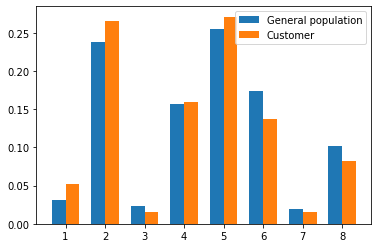

In [25]:
plot_clustering_results(X_train_cluster, y_train.squeeze(), n_clusters)

The clustering results may not be cleary differentiate the response and non-response individuals. Since the demographic of the existing customer and response individuals may not that related afterall.  

However, the trend of the proportion stay almost the same. For example  

* Cluster 2 --> the response proportion is greater than non-response proportion. 
* Cluster 3 and Cluster 7 --> the non-response proportion is greater than response proportion.

In [26]:
# since we use search cv model, we will use the full training data 
# and use cv score as generalization error
full_X_wcluster = append_cluster_feature('cleaning_pipeline.joblib', 'clustering_pipeline.joblib', full_X)

### Build the supervised model pipeline

#### Logistic classification

In [89]:
lc_dist = {
    'estimator__penalty': ['l1', 'l2', 'elasticnet'],
    'estimator__C': loguniform(1e-5, 10),
    'estimator__l1_ratio': uniform(0, 1)
}

In [90]:
# init sub components
scaler = StandardScaler()
lc_clf = LogisticRegression(class_weight='balanced', solver='saga')

lc_pipe = build_pipeline(scaler, lc_clf)
lc_cv = build_cv(lc_dist, lc_pipe)

In [91]:
lc_cv.fit(full_X_wcluster, full_y)

 The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The m

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('estimator',
                                              LogisticRegression(C=1.0,
                                                                 class_weight='balanced',
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 intercept_scaling=1,
                                                                 l1_ratio=None,
                                                                 max_ite

In [95]:
print(f'{lc_cv.best_params_}')
print(f'cv best score {lc_cv.best_score_}')
print(f'training score {roc_auc_score(full_y, lc_cv.predict_proba(full_X_wcluster)[:, 1])}')

{'estimator__C': 0.00032193798546707215, 'estimator__l1_ratio': 0.374827524931702, 'estimator__penalty': 'l2'}
cv best score 0.5835417398710804
training score 0.6931126169095314


In [97]:
# save the model
with open(MODEL_DIR / 'lc_cv.joblib', 'wb') as fp:
    joblib.dump(lc_cv, fp)

#### Random forest classifier

In [69]:
rf_dist = {
    'estimator__n_estimators': randint(2, 200),
    'estimator__max_depth': randint(2, 100),
    'estimator__min_samples_split': randint(10, 2000)
}

In [70]:
# init sub components
scaler = StandardScaler()
rf_clf = RandomForestClassifier(class_weight='balanced')

rf_pipe = build_pipeline(scaler, rf_clf)
rf_cv = build_cv(rf_dist, rf_pipe)

In [71]:
# fit and print best score
rf_cv.fit(full_X_wcluster, full_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('estimator',
                                              RandomForestClassifier(bootstrap=True,
                                                                     ccp_alpha=0.0,
                                                                     class_weight='balanced',
                                                                     criterion='gini',
                                                                     max_depth=None,
                                                                     max_features='auto',
                                     

In [72]:
print(f'{rf_cv.best_params_}')
print(f'cv best score {rf_cv.best_score_}')
print(f'training score {roc_auc_score(full_y, rf_cv.predict_proba(full_X_wcluster)[:, 1])}')

{'estimator__max_depth': 82, 'estimator__min_samples_split': 1027, 'estimator__n_estimators': 103}
cv best score 0.5813406992224117
training score 0.9540935468131531


In [87]:
# save the model
with open(MODEL_DIR / 'rf_cv.joblib', 'wb') as fp:
    joblib.dump(rf_cv, fp)

#### Adaboost

In [82]:
ada_dist = {
    'estimator__learning_rate': loguniform(1e-5, 10),
    'estimator__n_estimators': randint(3, 200),
    'estimator__base_estimator__max_depth': randint(1, 2),
    'estimator__base_estimator__min_samples_split': randint(10, 2000)
}

In [83]:
# init sub components
scaler = StandardScaler()
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(class_weight='balanced'))

ada_pipe = build_pipeline(scaler, ada_clf)
ada_cv = build_cv(ada_dist, ada_pipe)

In [84]:
# fit and print best score
ada_cv.fit(full_X_wcluster, full_y)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('estimator',
                                              AdaBoostClassifier(algorithm='SAMME.R',
                                                                 base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                                       class_weight='balanced',
                                                                                                       criterion='gini',
                                                                                                       max_de

In [85]:
print(f'{ada_cv.best_params_}')
print(f'cv best score {ada_cv.best_score_}')
print(f'training score {roc_auc_score(full_y, ada_cv.predict_proba(full_X_wcluster)[:, 1])}')

{'estimator__base_estimator__max_depth': 1, 'estimator__base_estimator__min_samples_split': 1484, 'estimator__learning_rate': 0.7272109104186818, 'estimator__n_estimators': 112}
cv best score 0.5683436658829029
training score 0.7442921970768505


In [88]:
# save the model
with open(MODEL_DIR / 'ada_cv.joblib', 'wb') as fp:
    joblib.dump(ada_cv, fp)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [98]:
mailout_test = pd.read_csv(DATA_DIR / 'Udacity_MAILOUT_052018_TEST.csv', sep=';')

/Users/boonchuay/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
model_name='ada_cv.joblib'
submission_fn='ada_cv_results.csv'
clean_pipe_fn='cleaning_pipeline.joblib'
clustering_pipe_fn='clustering_pipeline.joblib'

In [117]:
# predict the results
pred_proba, pred = full_predict(X=mailout_test, model_name=model_name, clean_pipe_fn=clean_pipe_fn, clustering_pipe_fn=clustering_pipe_fn)

In [118]:
# generate sumission results
generate_submission_results(X=mailout_test, pred_proba=pred_proba, submission_fn=submission_fn)